# Detectar un auto en una imagen con Object Detection Api [Tensorflow]

Importar las librerias necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw

import tensorflow as tf
import cv2 as cv


from pathlib import Path
from IPython.display import display
from collections import defaultdict
from io import StringIO

In [2]:
# Comandos para crear las librerias de object detection
# Ejecutarlas mediante shell
#$ cd models/research
#$ ./bin/protoc object_detection/protos/*.proto --python_out=.
#$ export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

<b>Ubicar direccion de la imagen</b>

In [4]:
PATH_IMAGEN = Path("../Imagenes/img_hummer.jpg")
if not PATH_IMAGEN.exists():
    print("La imagen {} no existe".format(PATH_IMAGEN))

<b>Establecer los datos del modelo</b>

In [5]:
#direccion del modelo
PATH_MODEL = Path('../ssd_mobilenet_v1_coco_2017_11_17/saved_model/')
if not PATH_MODEL.is_dir():
    print("La carpeta {} no existe".format(PATH_MODEL))

<b>Función para cargar el modelo</b>

In [6]:
def cargar_modelo(path_modelo):
    model = tf.saved_model.load(str(path_modelo))
    model = model.signatures['serving_default']  
    return model

<b>Función para Inferir un Frame/Imagen</b>

In [8]:
def inferir_imagen(modelo, img_Inicial):
    
    #Convertir la imagen en arreglo
    img_array = np.asarray(img_Inicial)
    
    # La entrada debe ser un tensor, convertirlo usando 'tf.convert_to_tensor'
    input_tensor = tf.convert_to_tensor(img_array)
    
    # El modelo espera las imagenes, asi que se agrega un eje con 'tf.newaxis'
    input_tensor = input_tensor[tf.newaxis,...]
    
    # Ejecutar la inferencia
    output_dict = modelo(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    num_detections = 7
    
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    
    # detection_classes deben ser ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    toReplace = np.where((output_dict['detection_classes'] != 8 ))
    output_dict['detection_scores'].flat[toReplace] = 0.00111111
    
    return output_dict

In [9]:
#Función para obtener las coordenadas a dibujar en la imagen
def calcular_Coordenadas(arr_coor,img_ancho,img_alto):
    #[(248,84),(248,139),(396,139),(396,84),(248,84)]
    (left, right, top, bottom) = (arr_coor[1] * img_ancho, arr_coor[3] * img_ancho,
                                  arr_coor[0] * img_alto, arr_coor[2] * img_alto)

    return [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)]

In [10]:
def showImage(path_img, coordenadas):
    img_original = Image.open(path_img)
    
    marco = ImageDraw.Draw(img_original)
    marco.line(coordenadas, fill="green",width=3)

    img_final = np.array(img_original)
    plt.imshow(img_final)
    plt.show()  

In [11]:
def getFrame(modelo, frame_base):
    img_inicial = np.array(frame_base)
    result_inferencia = inferir_imagen(model_detection, img_inicial)
    alto, ancho = frame_base.shape[0], frame_base.shape[1]
    
    #Si es un auto
    if (result_inferencia['detection_classes'][0] == 3) & (result_inferencia['detection_scores'][0] > float(0.45000000)):
        #print(result_inferencia['detection_scores'][0])
        
        coordenadas = calcular_Coordenadas(result_inferencia['detection_boxes'][0],ancho,alto)
    
        img_Pil = Image.fromarray(img_inicial)
        marco = ImageDraw.Draw(img_Pil)
        marco.line(coordenadas, fill="green",width=3) 
        #Regresa el freme con la deteccion del auto
        return np.asarray(img_Pil)
    
    #Regresa el frame igual
    return frame_base

In [12]:
# Cargar el modelo de detección
MODEL_DETECTION = cargar_modelo(PATH_MODEL)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
#Cargar imagen en formato de Numpy Array
img_np = np.array(Image.open(PATH_IMAGEN))

In [14]:
#Enviar la imagen para inferirla por el modelo
result_inferencia = inferir_imagen(MODEL_DETECTION, img_np)

In [15]:
#obtener el alto y el ancho de la imagen original
alto, ancho = img_np.shape[0], img_np.shape[1]

#Calcular la coordenada del objeto con el score más alto -> ['detection_boxes'][0]
coordenadas = calcular_Coordenadas(result_inferencia['detection_boxes'][0],ancho,alto)

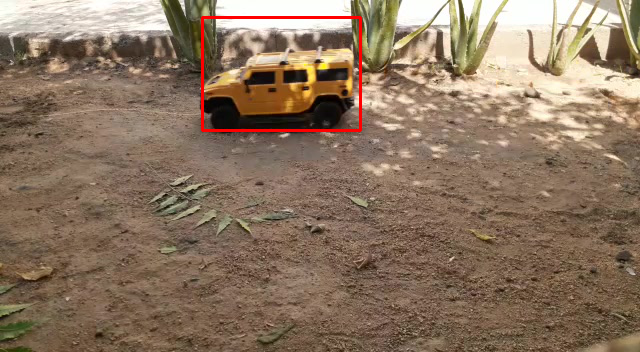

In [16]:
img_Pil = Image.fromarray(img_np)
marco = ImageDraw.Draw(img_Pil)
marco.line(coordenadas, fill="red",width=3)    
display(img_Pil)

In [17]:
print(coordenadas)

[(202.44911193847656, 17.801981449127197), (202.44911193847656, 130.74228286743164), (360.88077545166016, 130.74228286743164), (360.88077545166016, 17.801981449127197), (202.44911193847656, 17.801981449127197)]
